In [1]:
import sys
sys.path.append("..")

import os
import glob
import numpy as np

%load_ext autoreload
%autoreload 2

from sicm import io, plots, model

# Simulations
## Current-distance characterstic

In [2]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3/"
files = glob.glob(parent + "*.txt")
print(files)

['S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3\\ecJ3D.txt']


Saved figure to I_vs_d_curve.pdf.


C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


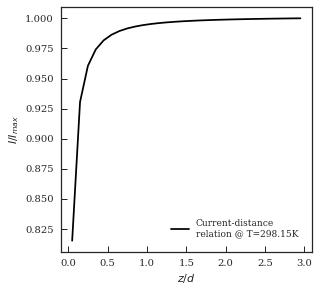

In [3]:
# Current-distance simulation
data = io.load_comsol(files[0])
r_i = 15e-9
x = data.iloc[:, 0] / (r_i*2) # scale by diameter
y = np.asarray(data.iloc[:, 1]) # convert to nanoAmps
y_max = np.max(y) if y[-1] > 0 else np.min(y)
y = y/y_max
leg = "Current-distance relation @ T=298.15K"
plots.plot_generic([x], [y], [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve")

## Current-temperature characteristic

You may need to rerun the simulation and sample current also at d = `some-very-high-value` in order to plot relative current as well.

['S:/UsersData/Martin/projects/thermometry/comsol/I_vs_Tsub/3\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/I_vs_Tsub/3\\ecJ3D.txt']
Saved figure to I_vs_Tsub_curve.pdf.


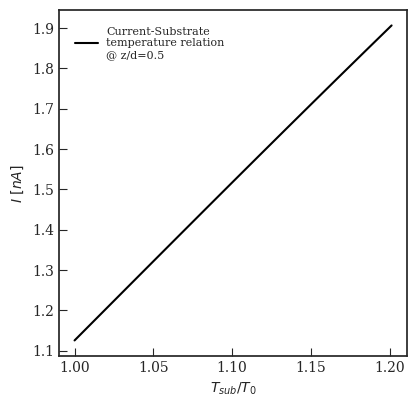

In [4]:
# Current-Tsub simulation
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_Tsub/3/"
files = glob.glob(parent + "*.txt")
print(files)

data = io.load_comsol(files[0])
x = data.iloc[:, 0] / (data.iloc[0, 0]) # scale by room temperature
y = np.abs(data.iloc[:, 2])*1e9 # convert to nanoAmps
leg = "Current-Substrate temperature relation @ z/d=0.5"
plots.plot_generic([x], [y], [r"$T_{sub}/T_{0}$"], [r"$I\ [nA]$"], leg, "I vs. Tsub curve")

# Analytical model

Saved figure to I_vs_z_curve.pdf.


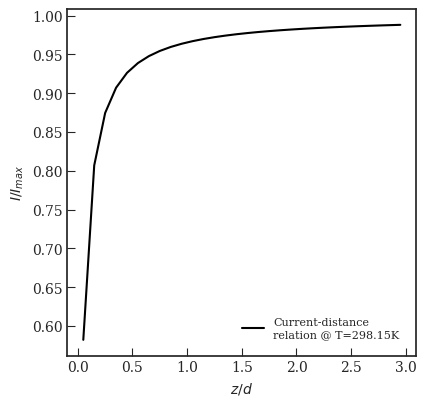

In [37]:
# Analytical Model
r_i = 15e-9
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6
r_p = 2e-6
r_o = 26e-9
z = np.arange(r_i/10, 6*r_i, r_i/5)

sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)
sicm_model.plot(do_invert = False)

# Fit functional relationship to data

Fit function of the form of an analytical model to the simulations data. Use inverted relationship $d = f(I)$ and prefer to work with scaled values $\frac{d}{2r_i} = f(\frac{I}{I_{max}})$.

Result is acceptable, although the fitted parameters are not physical as $r_p$ comes out negative and $\kappa$ is not as prescribed by the conductivity model. 

I have tried using bounds on parameters, different scaling of parametrs and different methods of `curve_fit` but none really worked. For now, I let it be as I care only about the prediciton for d, but in future, I may want to try rewriting the prescription to a different form and see if this helps.

I also should run the simulation with higher resolution to obtain more data fpr the fit, especially at low values of $d/r_i$

In [2]:
# obtain a model that yields distance for some measured current
r_i = 15e-9
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6
r_p = 2e-6
r_o = 26e-9
z = np.arange(r_i/10, 6*r_i, r_i/5)

# continue here by fitting inverse relationship
sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)

In [3]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3/"
files = glob.glob(parent + "*.txt")
data = io.load_comsol(files[0])
z = data.iloc[:, 0]
i = np.abs(np.asarray(data.iloc[:, 1]))
i_max = np.max(i)

## Version A 

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 30 datapoints ...
Found parameters: [9.66533188e-07 4.18163001e-05 1.05302638e+01].
Finished in 0.004 s
error on fit: 3.377107158E-02


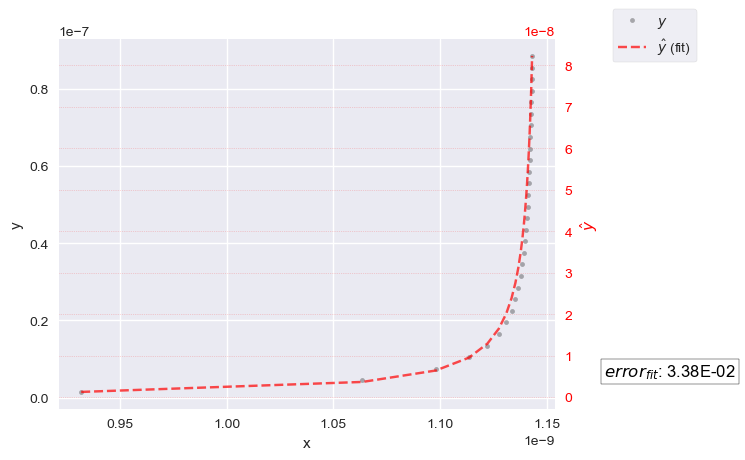

In [409]:
guess = [r_p, h, kappa**2]
sicm_model.fit_approach(z, i, guess)

error on fit: 3.377107158E-02


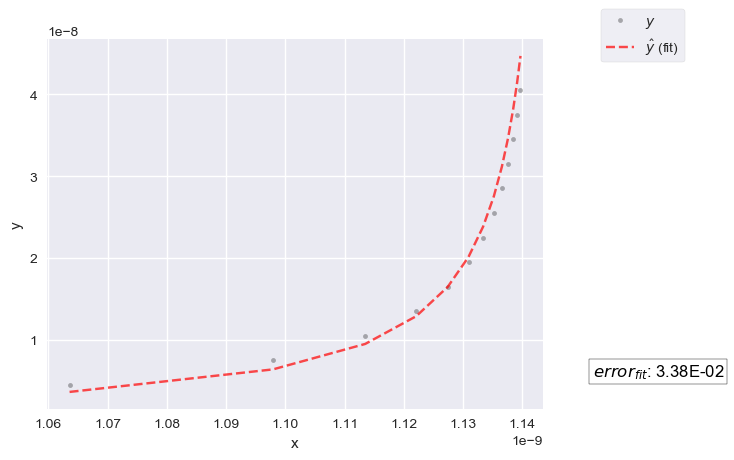

In [410]:
sicm_model.plot_fit(z, i, plot_range = [1.05e-9, 1.14e-9])

## Version B

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 30 datapoints ...
Found parameters: [-1.42929142e-06 -1.99959038e-12  2.97821509e+02].
Finished in 0.010 s
error on fit: 1.999305375E-02


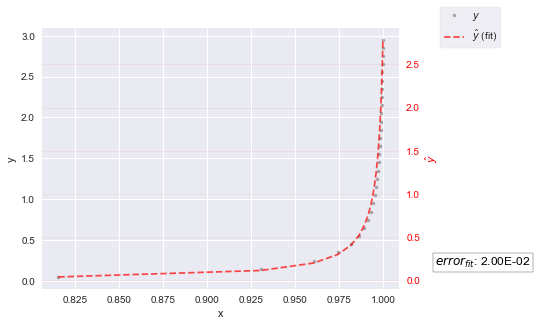

In [4]:
guess = [r_p, h*r_i, np.sqrt((kappa**2)/(i_max/U))]
sicm_model.fit_approach(z/(2*r_i), i/i_max, guess)

error on fit: 1.999305375E-02


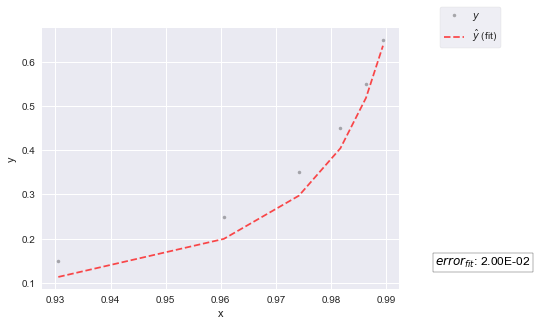

In [5]:
sicm_model.plot_fit(z/(2*r_i), i/i_max, plot_range = [0.925, .99])

## Get distance from experimental data

In [33]:
'S:/UsersData/Martin/2018/12_Dec/21\\scan1_annot.pkl'
data_dir = "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp1"
# data_dir = "S:/UsersData/Martin/2018/12_Dec/21"
exp_name = "scan_hopping_qtf_current"
# exp_name = "scan1"
df = io.load_dataframe([data_dir, exp_name + "_annot.pkl"])

Saved figure to scan_hopping_qtf_current_feedback_distance.pdf.


C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


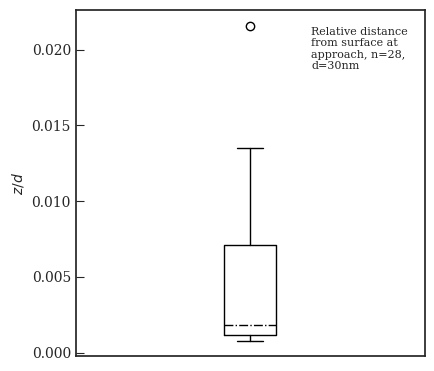

In [34]:
i_exp = df["Current1(A)"]["peaks_val"]/df["Current1(A)"]["baseline"]
z_rel = sicm_model.predict(i_exp)
legend = "Relative distance from surface at approach," + \
        " n={}, d={:.0f}nm".format(len(z_rel), np.round(2*r_i*1e9))
plots.boxplot_generic(z_rel, "", r"$z/d$", legend = legend,
                     fname = exp_name + "_feedback_distance")